In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

## Introduction

We start by opening the data and creating a pandas dataframe with all the information form the dataset. We set the "Start Date" field as the index to make data manipulation easier.

In [3]:
df = pd.read_csv("../data/EVChargingStationUsage.csv")
df["Start Date"] = pd.to_datetime(df["Start Date"])
df["Charging Time (hh:mm:ss)"] = pd.to_timedelta(df["Charging Time (hh:mm:ss)"])
df = df.set_index(df["Start Date"])

C:\Users\vbran\AppData\Local\Temp\ipykernel_8520\587786845.py:1: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/EVChargingStationUsage.csv")


We will only use fields described below for the task of predicting consumption. 

In [4]:
df = df[["Address 1", "Energy (kWh)", "Charging Time (hh:mm:ss)"]]
df

,Address 1,Energy (kWh),Charging Time (hh:mm:ss)
Start Date,,,
2011-07-29 20:17:00,250 Hamilton Ave,6.249457,0 days 01:54:03
2011-07-30 00:00:00,250 Hamilton Ave,0.106588,0 days 00:01:54
2011-07-30 08:16:00,250 Hamilton Ave,14.951777,0 days 04:17:28
2011-07-30 14:51:00,250 Hamilton Ave,7.159643,0 days 02:02:58
2011-07-30 18:51:00,250 Hamilton Ave,1.957765,0 days 00:43:54
...,...,...,...
2020-12-31 16:39:00,275 Cambridge Ave,1.841000,0 days 00:35:18
2020-12-31 16:48:00,520 Webster St,12.744000,0 days 02:14:04
2020-12-31 17:28:00,3700 Middlefield Rd,29.665000,0 days 05:08:12


## Data cleaning and reformating

Now we have to reformat the data so that instead of displaying consumption for each time a car was charged on a station, we want to have aggrigated data with total consumption for the whole hour for each of the stations. We will use 2 assumptions to get this: The first is a constant consumption throughout the whole charging period and the second one is that every car starts charging immediately after arriving at the charging station.

In [5]:
max_charge_time = max(df["Charging Time (hh:mm:ss)"])
def get_hourly_consumption(df: pd.DataFrame) -> pd.Series:
    first_datetime = df.index.min().replace(minute=0, second=0)
    last_datetime = (df.index.max() + max_charge_time).replace(minute=0, second=0)
    hourly_index = pd.date_range(first_datetime, last_datetime, freq="h")
    hourly_df = pd.Series(0.0, index=hourly_index)
    for index, row in df.iterrows():
        current_datetime = index
        total_consumption = row["Energy (kWh)"]
        total_duration = row["Charging Time (hh:mm:ss)"]
        end_datetime = index + total_duration
        while current_datetime < end_datetime:
            start_hour = current_datetime.replace(minute=0, second=0)   #type: ignore
            end_hour = start_hour + pd.Timedelta(hours=1)
            sub_duration = min(end_hour, end_datetime) - current_datetime
            sub_consumption = total_consumption * sub_duration / total_duration
            hourly_df[start_hour] += sub_consumption
            current_datetime = end_hour
    return hourly_df

In [6]:
station_names = df['Address 1'].unique()
len(station_names)

20

There are a total of 20 charging stations in the dataset. Lets create a dictionary with station names as keys and hourly energy consumption dataframe as values.

In [7]:
hourly_consumption_by_station = dict()
for i, station_name in enumerate(station_names):
    station_df = df[df["Address 1"] == station_name]
    consumption = get_hourly_consumption(station_df)
    hourly_consumption_by_station[station_name] = consumption

In [8]:
hourly_consumption_by_station["250 Hamilton Ave"].head()

2011-07-29 20:00:00    2.356218
2011-07-29 21:00:00    3.287746
2011-07-29 22:00:00    0.605493
2011-07-29 23:00:00    0.000000
2011-07-30 00:00:00    0.106588
Freq: H, dtype: float64

## Seasonality and trend visualisation

Now we plot hourly, daily and monthly graphs for 3 arbitrarily chosen stations to observe seasonality and trends in our data.

In [7]:
def plot_consumption(hourly_consumption: pd.Series):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plot_day_consumption(hourly_consumption, axes[0])
    plot_week_consumption(hourly_consumption, axes[1])
    plot_year_consumption(hourly_consumption, axes[2])
    plt.show()

def plot_day_consumption(hourly_consumption: pd.Series, ax):
    if type(hourly_consumption.index) != pd.DatetimeIndex:
        raise ValueError("The index of the input Series must be a DatetimeIndex")
    hourly_grouped = hourly_consumption.groupby(hourly_consumption.index.hour)
    data = [hourly_grouped.get_group(hour).values for hour in range(24) if hour in hourly_grouped.groups]
    ax.boxplot(data, positions=range(len(data)), widths=0.6, patch_artist=True, showmeans=True, showfliers=False)
    ax.set_xlabel("Hour of the day")
    ax.set_ylabel("Average consumption (kWh)")
    ax.set_title("Average consumption per hour of the day")
    legend_elements = [
        plt.Line2D([0], [0], color='orange', lw=2, label='Median'), #type: ignore
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=10, label='Mean') #type: ignore
    ]
    ax.legend(handles=legend_elements, loc='upper right')

def plot_week_consumption(hourly_consumption: pd.Series, ax):
    # Group data by day of the week
    if type(hourly_consumption.index) != pd.DatetimeIndex:
        raise ValueError("The index of the input Series must be a DatetimeIndex")
    weekly_data = [
        hourly_consumption[hourly_consumption.index.dayofweek == day].values
        for day in range(7)
    ]
    
    # Draw the boxplot
    ax.boxplot(weekly_data, positions=range(7), widths=0.6, patch_artist=True, showmeans=True, showfliers=False)
    ax.set_xlabel("Day of the week")
    ax.set_ylabel("Consumption (kWh)")
    ax.set_title("Distribution of Consumption per Day of the Week")
    ax.set_xticks(range(7))
    ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    legend_elements = [
        plt.Line2D([0], [0], color='orange', lw=2, label='Median'), #type: ignore
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=10, label='Mean') #type: ignore
    ]
    ax.legend(handles=legend_elements, loc='upper right')


def plot_year_consumption(hourly_consumption: pd.Series, ax):
    if type(hourly_consumption.index) != pd.DatetimeIndex:
        raise ValueError("The index of the input Series must be a DatetimeIndex")
    # Group data by month
    monthly_data = [
        hourly_consumption[hourly_consumption.index.month == month].values
        for month in range(1, 13)
    ]
    
    # Draw the boxplot
    ax.boxplot(monthly_data, positions=range(1, 13), widths=0.6, patch_artist=True, showmeans=True, showfliers=False)
    ax.set_xlabel("Month")
    ax.set_ylabel("Consumption (kWh)")
    ax.set_title("Distribution of Consumption per Month")
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels([
        "Jan", "Feb", "Mar", "Apr", "May", "Jun",
        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
    ])
    legend_elements = [
        plt.Line2D([0], [0], color='orange', lw=2, label='Median'), #type: ignore
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=10, label='Mean') #type: ignore
    ]
    ax.legend(handles=legend_elements, loc='upper right')


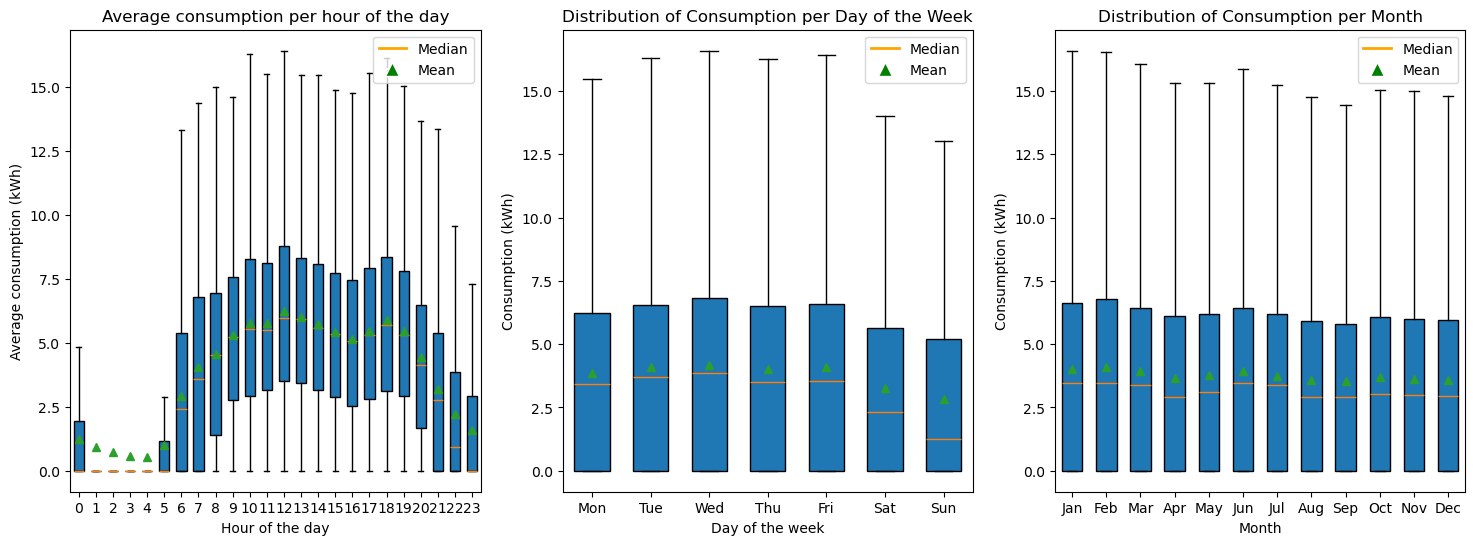

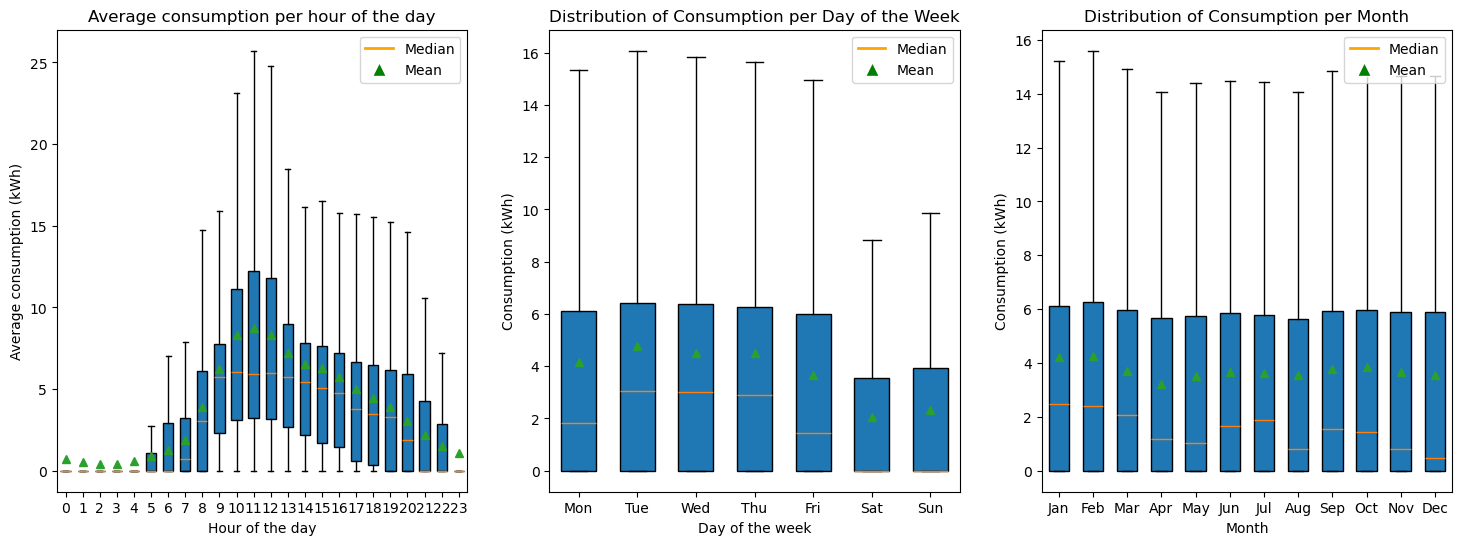

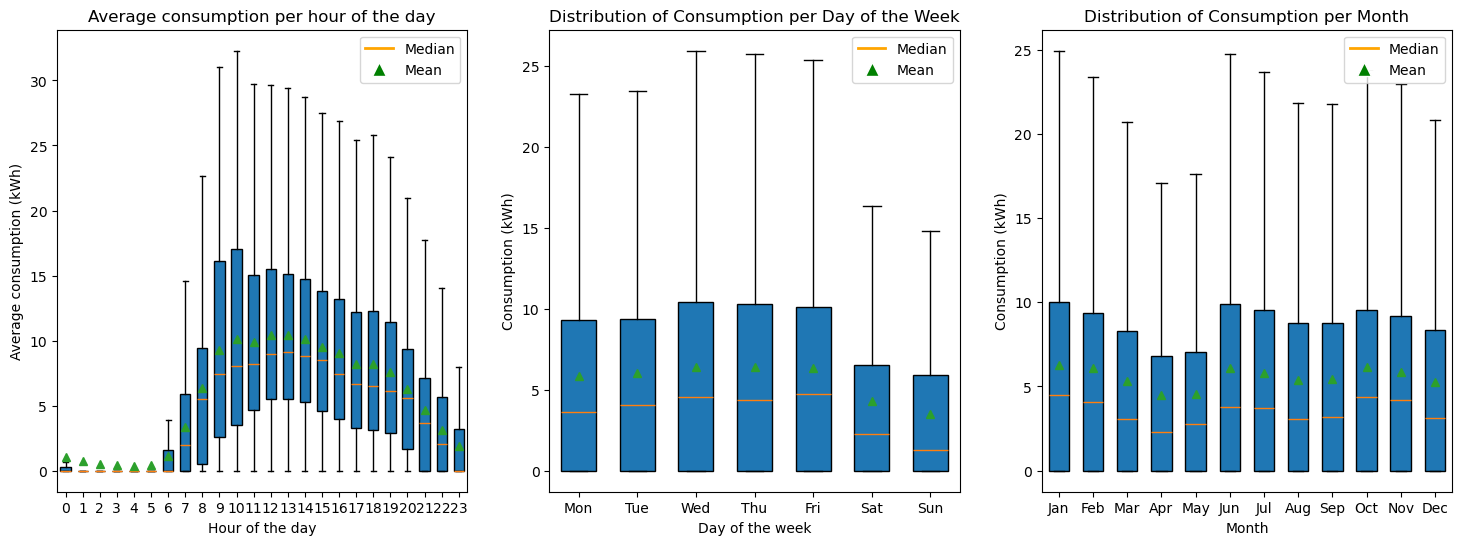

In [8]:
selected_stations = ["250 Hamilton Ave", "275 Cambridge Ave", "520 Webster St"]
for station_name in selected_stations:
    plot_consumption(hourly_consumption_by_station[station_name])

We can see the consumption is higher during the day and during weekdays. Consumption during different months seems to be more balanced, depending on the station.

Now lets visualize the trends in the data for the same 3 stations. We used daily consumption to make the graphs more readable.

In [9]:
def plot_trends(hourly_consumption: pd.Series):
    daily_consumption = hourly_consumption.resample("D").sum()
    weekly_window = daily_consumption.rolling(window=7).mean()
    yearly_window = daily_consumption.rolling(window=365).mean()

    # Plot daily, 7-day rolling mean, and 365-day rolling mean time series
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(daily_consumption, marker='.', markersize=2, color='0.6',
    linestyle='None', label='Daily')
    ax.plot(weekly_window, linewidth=2, label='7-d Rolling Mean')
    ax.plot(yearly_window, color='0.2', linewidth=3,
    label='Trend (365-d Rolling Mean)')

    ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel('Consumption (kWh)')
    ax.set_title('Charging Station Consumption Trend')

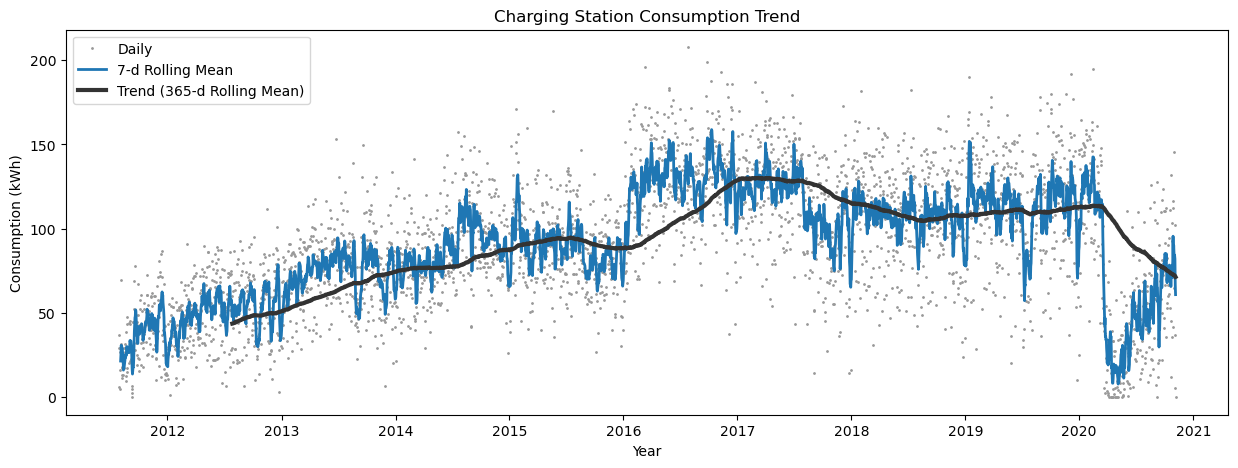

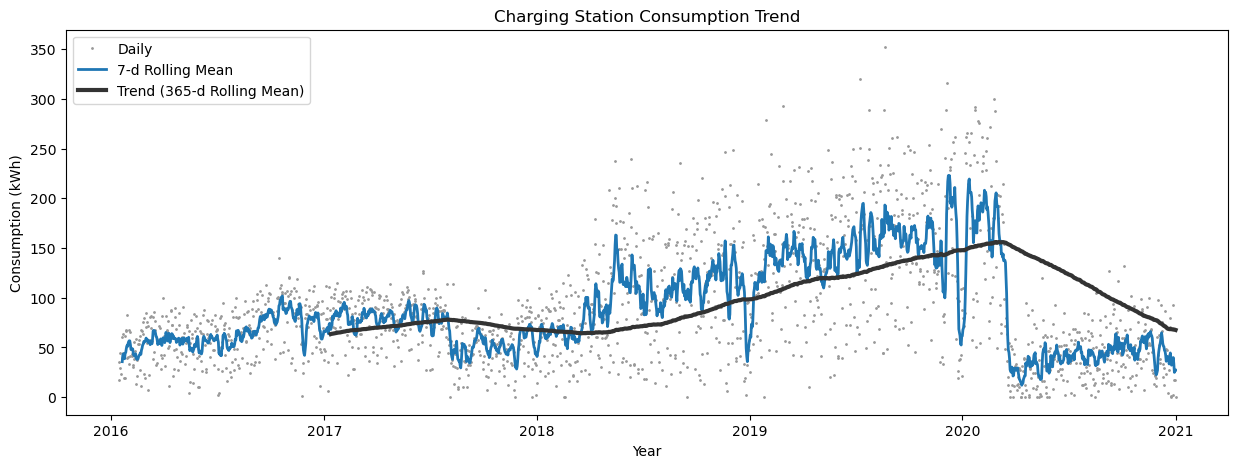

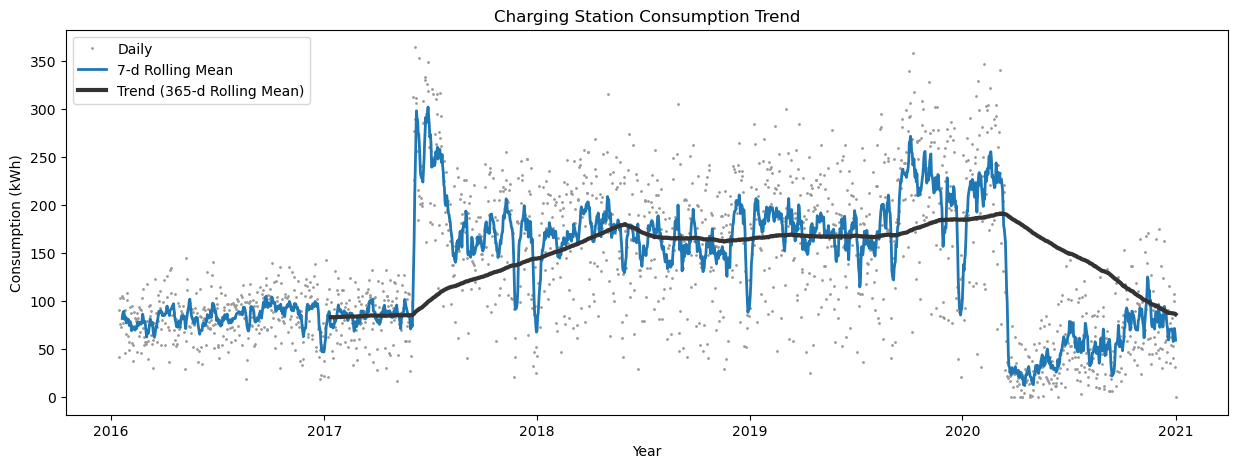

In [10]:
for station_name in selected_stations:
    plot_trends(hourly_consumption_by_station[station_name])

An interesting change of trends seem to occur in year 2020, probably due to the global pandemic.

## Autocorrelation and partial autocorrelation

Before building any model, we need to see how many datapoints from the past should we use in our autoregressive model. We can use plot_acf and plot_pacf methods to help us decide.

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_autocorrelations(consumption: pd.Series):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(consumption, ax=axs[0])
    plot_pacf(consumption, ax=axs[1])
    plt.show()

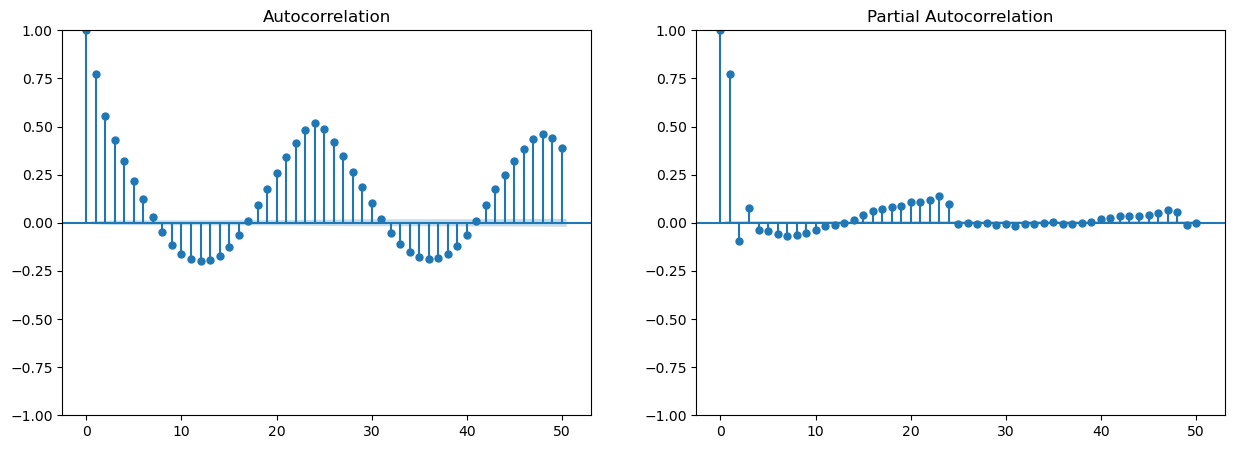

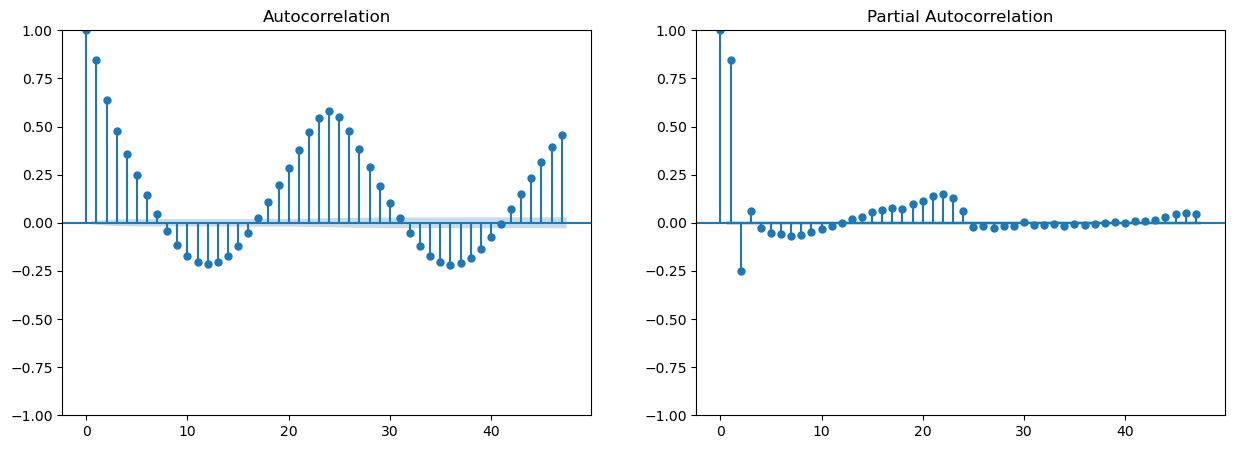

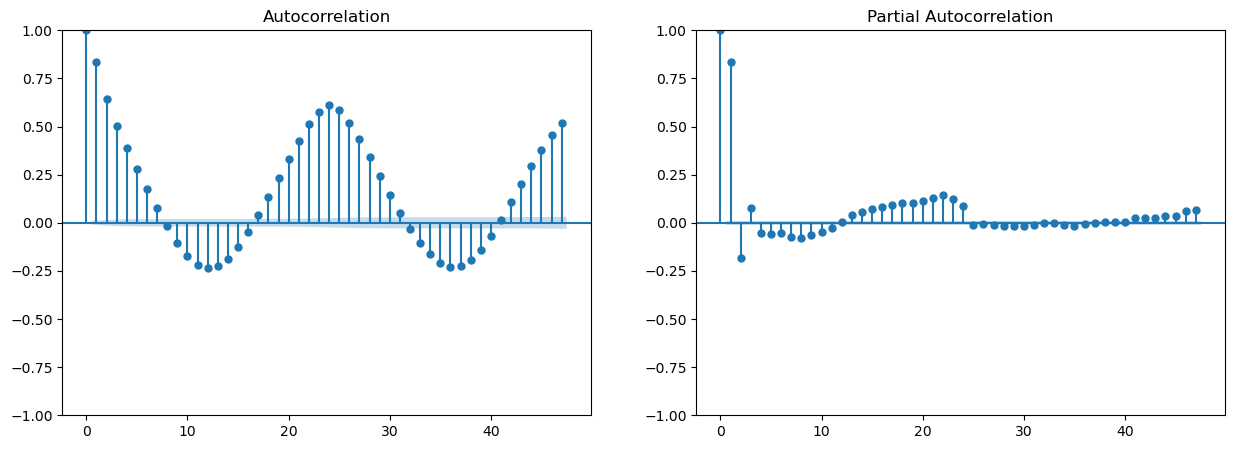

In [12]:
for station_name in selected_stations:
    plot_autocorrelations(hourly_consumption_by_station[station_name])

The graphs suggest that using past 3 hours along with the same hour of the previous days (indicated by the peak at 24 hour delay in the graphs).

## Stationarity

The last step before building a model is determining stationarity. Looking at the graphs in the trend section, the data does not seem to stationary, but we can confirm that with a ADF test.

In [13]:
from statsmodels.tsa.stattools import adfuller

def print_adf_results(consumption: pd.Series):
    result = adfuller(consumption)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():    #type: ignore
        print('\t%s: %.3f' % (key, value))

We will perform the test on both hourly and daily data

In [14]:
for station_name in selected_stations:
    print(f"Station: {station_name}")
    print_adf_results(hourly_consumption_by_station[station_name])

Station: 250 Hamilton Ave
ADF Statistic: -17.327079
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Station: 275 Cambridge Ave
ADF Statistic: -16.691114
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Station: 520 Webster St
ADF Statistic: -14.263183
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [15]:
for station_name in selected_stations:
    print(f"Station: {station_name}")
    print_adf_results(hourly_consumption_by_station[station_name].resample("D").sum())

Station: 250 Hamilton Ave
ADF Statistic: -3.040040
p-value: 0.031321
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Station: 275 Cambridge Ave
ADF Statistic: -2.656086
p-value: 0.081950
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Station: 520 Webster St
ADF Statistic: -2.869156
p-value: 0.049054
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Interestingly, the hourly data seems to be stationary while daily data does not. The reason might be that there is a long term trend (over years) which hourly test can't detect.

## Creating training and test data

In [16]:
test_size = 0.3
training_data = dict()
test_data = dict()

for station_name, hourly_df in hourly_consumption_by_station.items():
    if len(hourly_df) < 7 * 24:
        print(f"Skipping {station_name} due to insufficient data")
        continue

    # Calculate the split index based on test size
    split_index = int(len(hourly_df) * (1 - test_size))
    
    # Get the timestamp corresponding to the split index
    split_timestamp = hourly_df.index[split_index]
    
    # Adjust the split index to the next midnight (start of the day)
    adjusted_split_index = hourly_df.index.get_loc(
        hourly_df[hourly_df.index >= split_timestamp.normalize()].index[0]
    )
    
    # Perform the split
    training_split = hourly_df.iloc[:adjusted_split_index]
    test_split = hourly_df.iloc[adjusted_split_index:]
    
    # Remove the last day's data from the test split
    if not test_split.empty:
        last_day_start = test_split.index[-1].normalize()
        test_split = test_split[test_split.index < last_day_start]
    
    # Assign splits to dictionaries
    training_data[station_name] = training_split
    test_data[station_name] = test_split


Skipping 533 Cowper St due to insufficient data
Skipping 520 Cowper St due to insufficient data


## Baseline model

We decided to use historical averages for each hour of the day in the week for our baseline model.

In [17]:
# Filter for each day of the week
days_in_week = 7
daily_distributions = []
columns = ["Station", "r^2 Baseline", "MAE Baseline", "r^2 XGBoost", "MAE XGBoost"]
stats = pd.DataFrame(columns=columns)
stats["Station"] = list(training_data.keys())
stats.set_index("Station", inplace=True)
baseline_predictions = []
for station_name in training_data.keys():
    train = training_data[station_name]
    test = test_data[station_name]
    for day in range(days_in_week):
        day_of_week_data = train[train.index.dayofweek == day]
        daily_distributions.append(day_of_week_data.groupby(day_of_week_data.index.hour).mean())

    # Create predictions
    predictions = []
    for i in range(len(test)):
        day_of_week = test.index[i].dayofweek
        hour = test.index[i].hour
        predictions.append(daily_distributions[day_of_week][hour])

    # Calculate and print stats and plot results
    stats.loc[station_name]["r^2 Baseline"] = r2_score(test.values, predictions)
    stats.loc[station_name]["MAE Baseline"] = mean_absolute_error(test.values, predictions)
    baseline_predictions.append(predictions)

In [18]:
def plot_all_predicted_vs_actual(y_tests, y_preds, names, start=0, end=168):
    fig, axes = plt.subplots(6,3, figsize=(21,35))
    axes = axes.flatten()
    for y_test, y_pred, name, ax in zip(y_tests, y_preds, names, axes):
        min_len = min([len(y_test), len(y_pred), end])
        ax.plot(y_test.index[start:min_len], y_test[start:min_len], label="Actual")
        ax.plot(y_test.index[start:min_len], y_pred[start:min_len], label="Predicted")
        ax.set_title(name)
        ax.legend(["Actual", "Predicted"])
        ax.tick_params(axis='x', rotation=45)
    plt.subplots_adjust(hspace=0.5)
    plt.show()

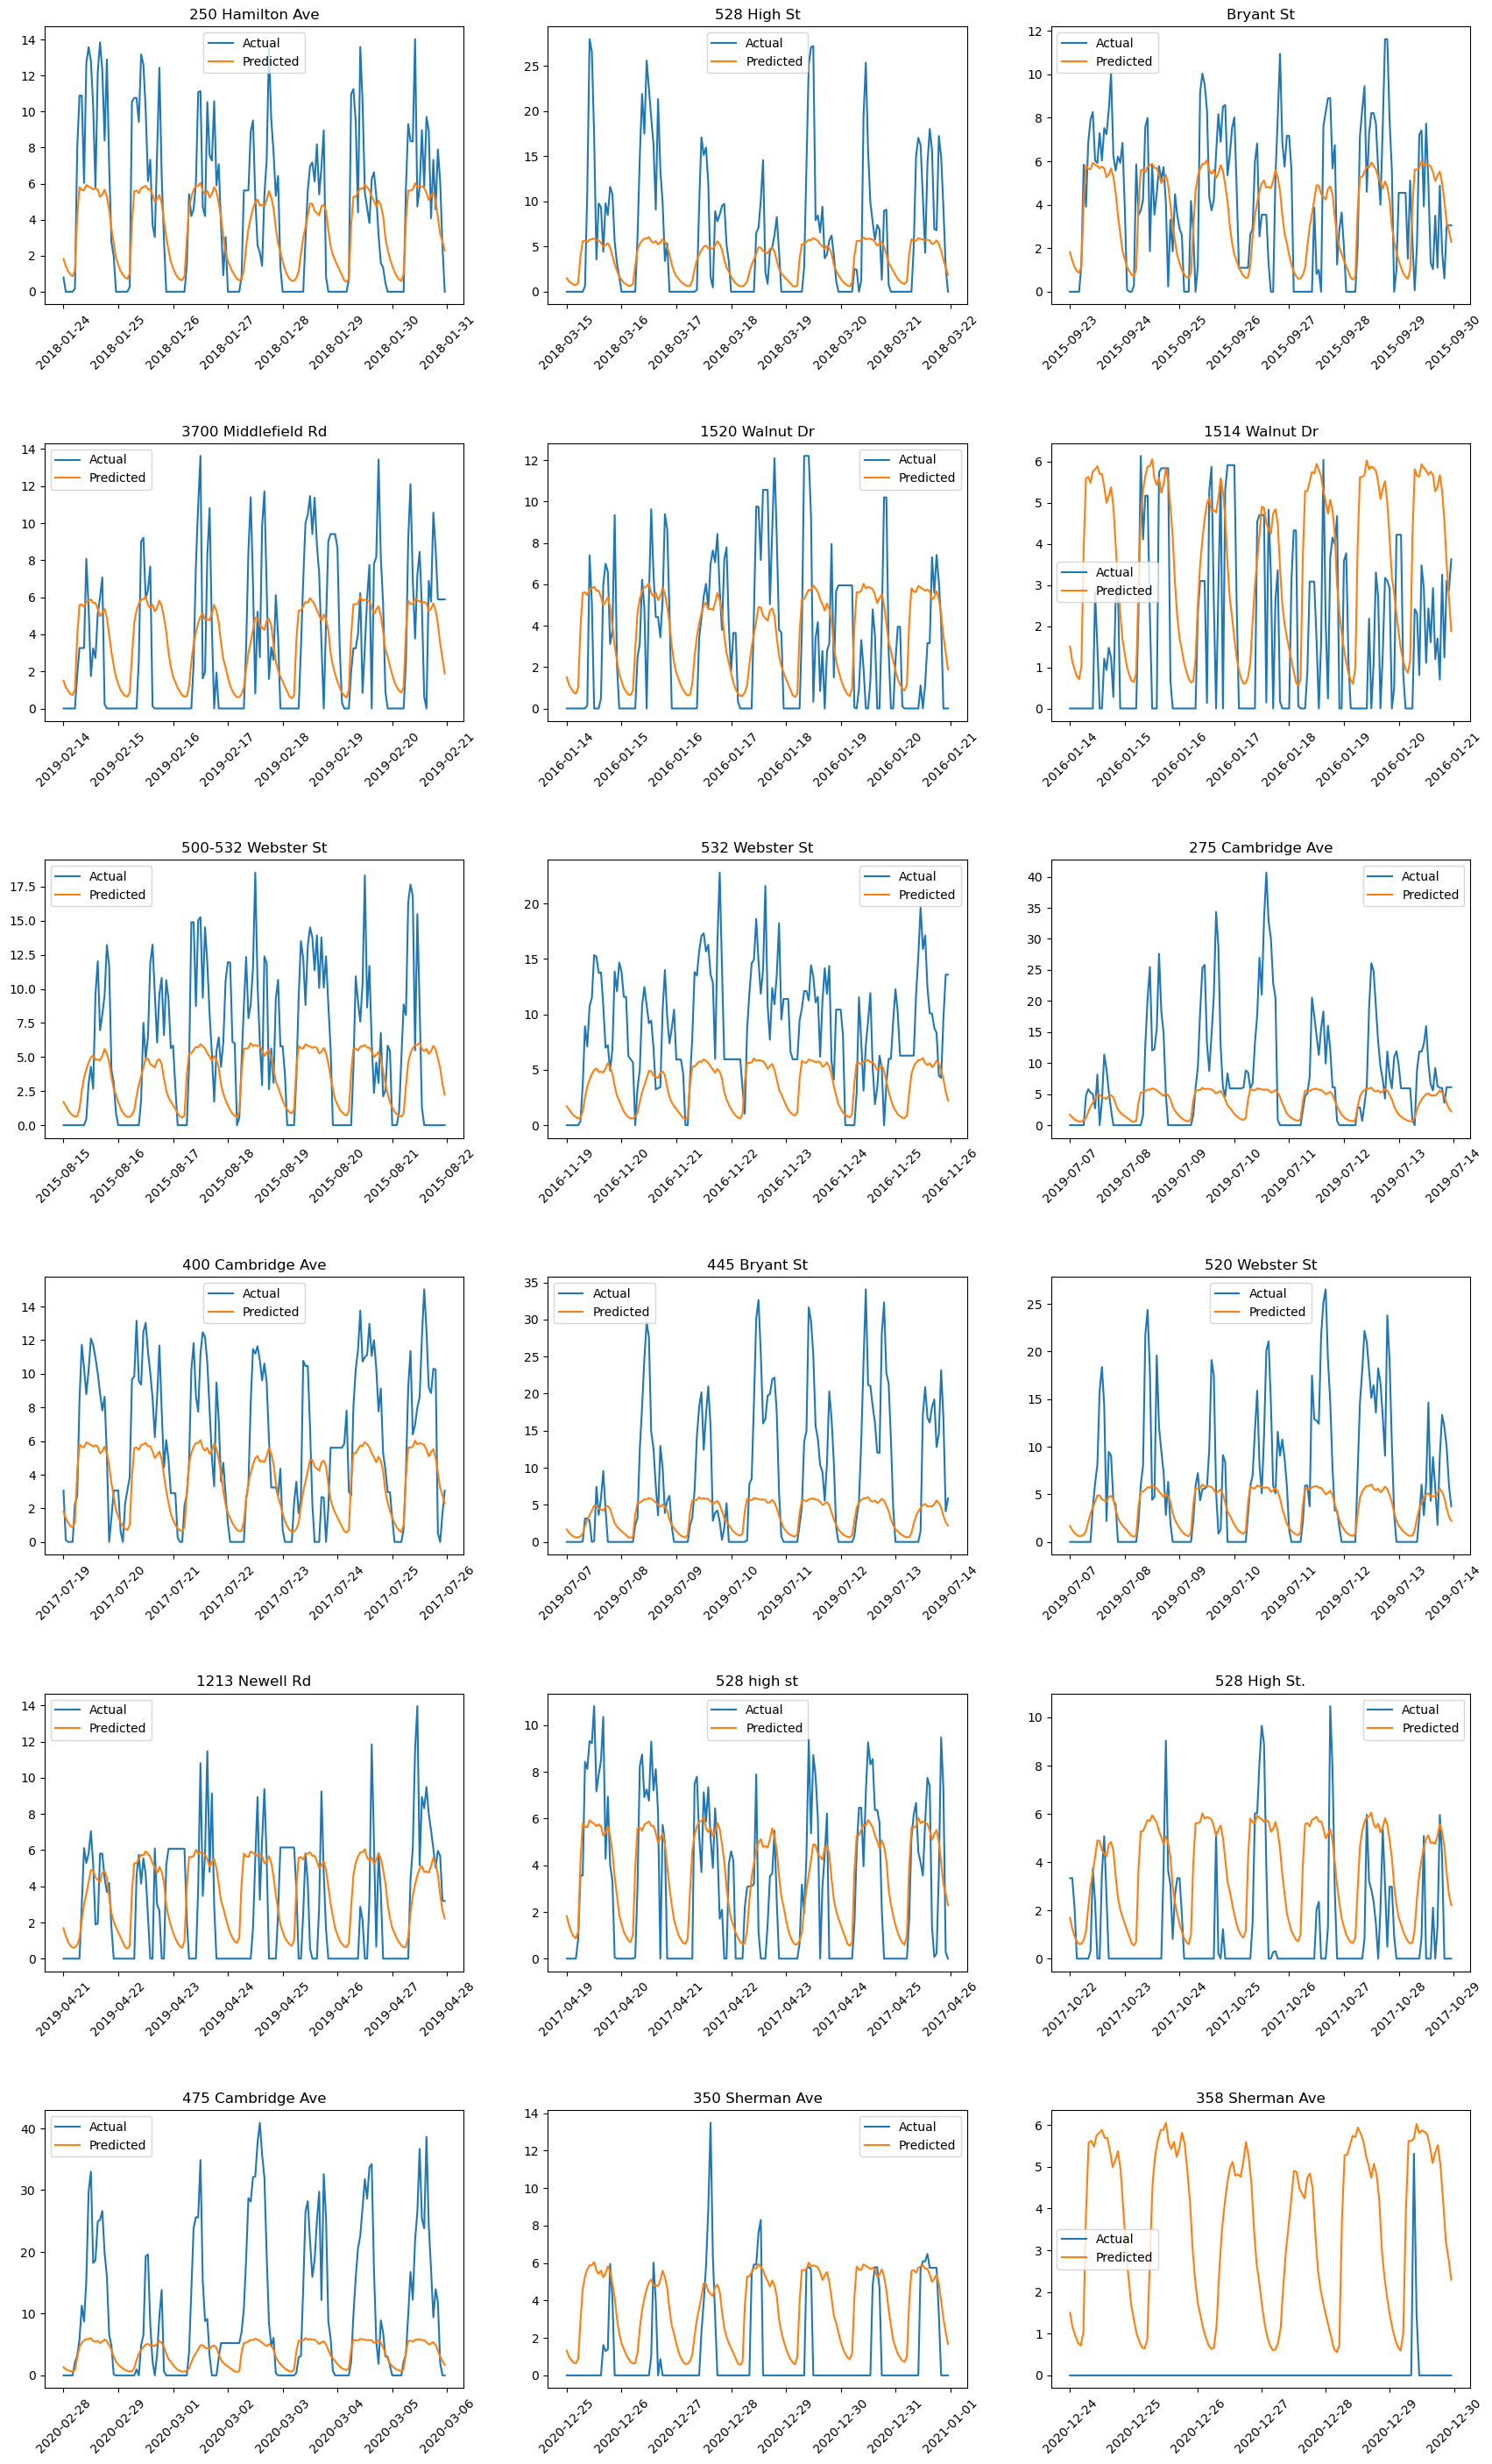

In [19]:
plot_all_predicted_vs_actual(test_data.values(), baseline_predictions, list(training_data.keys()))

For our prediction model, we decided to use XGBoost, since it has shown to perform well on time series forecasting. The idea is to use a number of data points from previous hours along with additional features such as "hour", "day_of_week", "is_weekend" and "month" to help the model make predictions. When training, the model uses true past values, and when testing, it uses the past predictions. Then, at the end of the day, the predictions are replaced with true values before making predictions for the next day.

## XGB model

In [20]:
from xgboost import XGBRegressor

# Function to create lag features
lags = [1, 2, 3, 24, 48, 72, 96]
limit_in_days = None
def create_features(df: pd.DataFrame, y_variable: str) -> pd.DataFrame:
    if type(df.index) != pd.DatetimeIndex:
        raise ValueError("Index of the DataFrame must be a DatetimeIndex") 
    for lag in lags:
        df[f"lag_{lag}"] = df[y_variable].shift(lag)
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)
    df["month"] = df.index.month
    return df

def train_model(hourly_df: pd.DataFrame, y_variable: str) -> XGBRegressor:
    features_df = create_features(pd.DataFrame(hourly_df, columns=[y_variable]), y_variable)
    features_df = features_df.dropna().reset_index(drop=True)

    # Splitting into features and target
    X_train = features_df.drop(columns=[y_variable])
    y_train = features_df[y_variable]

    model = XGBRegressor(n_estimators=100, learning_rate=0.16, max_depth=7, random_state=42)
    model.fit(X_train, y_train)
    return model

def test_model(model: XGBRegressor, targets: pd.Series, last_known_data: pd.Series) -> pd.Series:
    predictions = pd.Series()  # Store all predictions
    i = 0
    for dt in targets.index:
        new_row = {f"lag_{lag}": last_known_data.iloc[-lag] for lag in lags}
        new_row["hour"] = dt.hour
        new_row["dayofweek"] = dt.dayofweek
        new_row["is_weekend"] = int(dt.dayofweek in [5, 6])
        new_row["month"] = dt.month
        prediction = model.predict(pd.DataFrame(new_row, index=[0]))
        predictions[dt] = prediction[0]
        last_known_data = pd.concat([last_known_data.iloc[1:], pd.Series(prediction[0], index=[dt])])

        if dt.hour == 23:
            i+=1
            last_known_data = pd.concat([last_known_data.iloc[:-24], pd.Series(targets[targets.index.normalize() == dt.normalize()])])  # type: ignore
            if limit_in_days is not None and i == limit_in_days:
                break

    return predictions

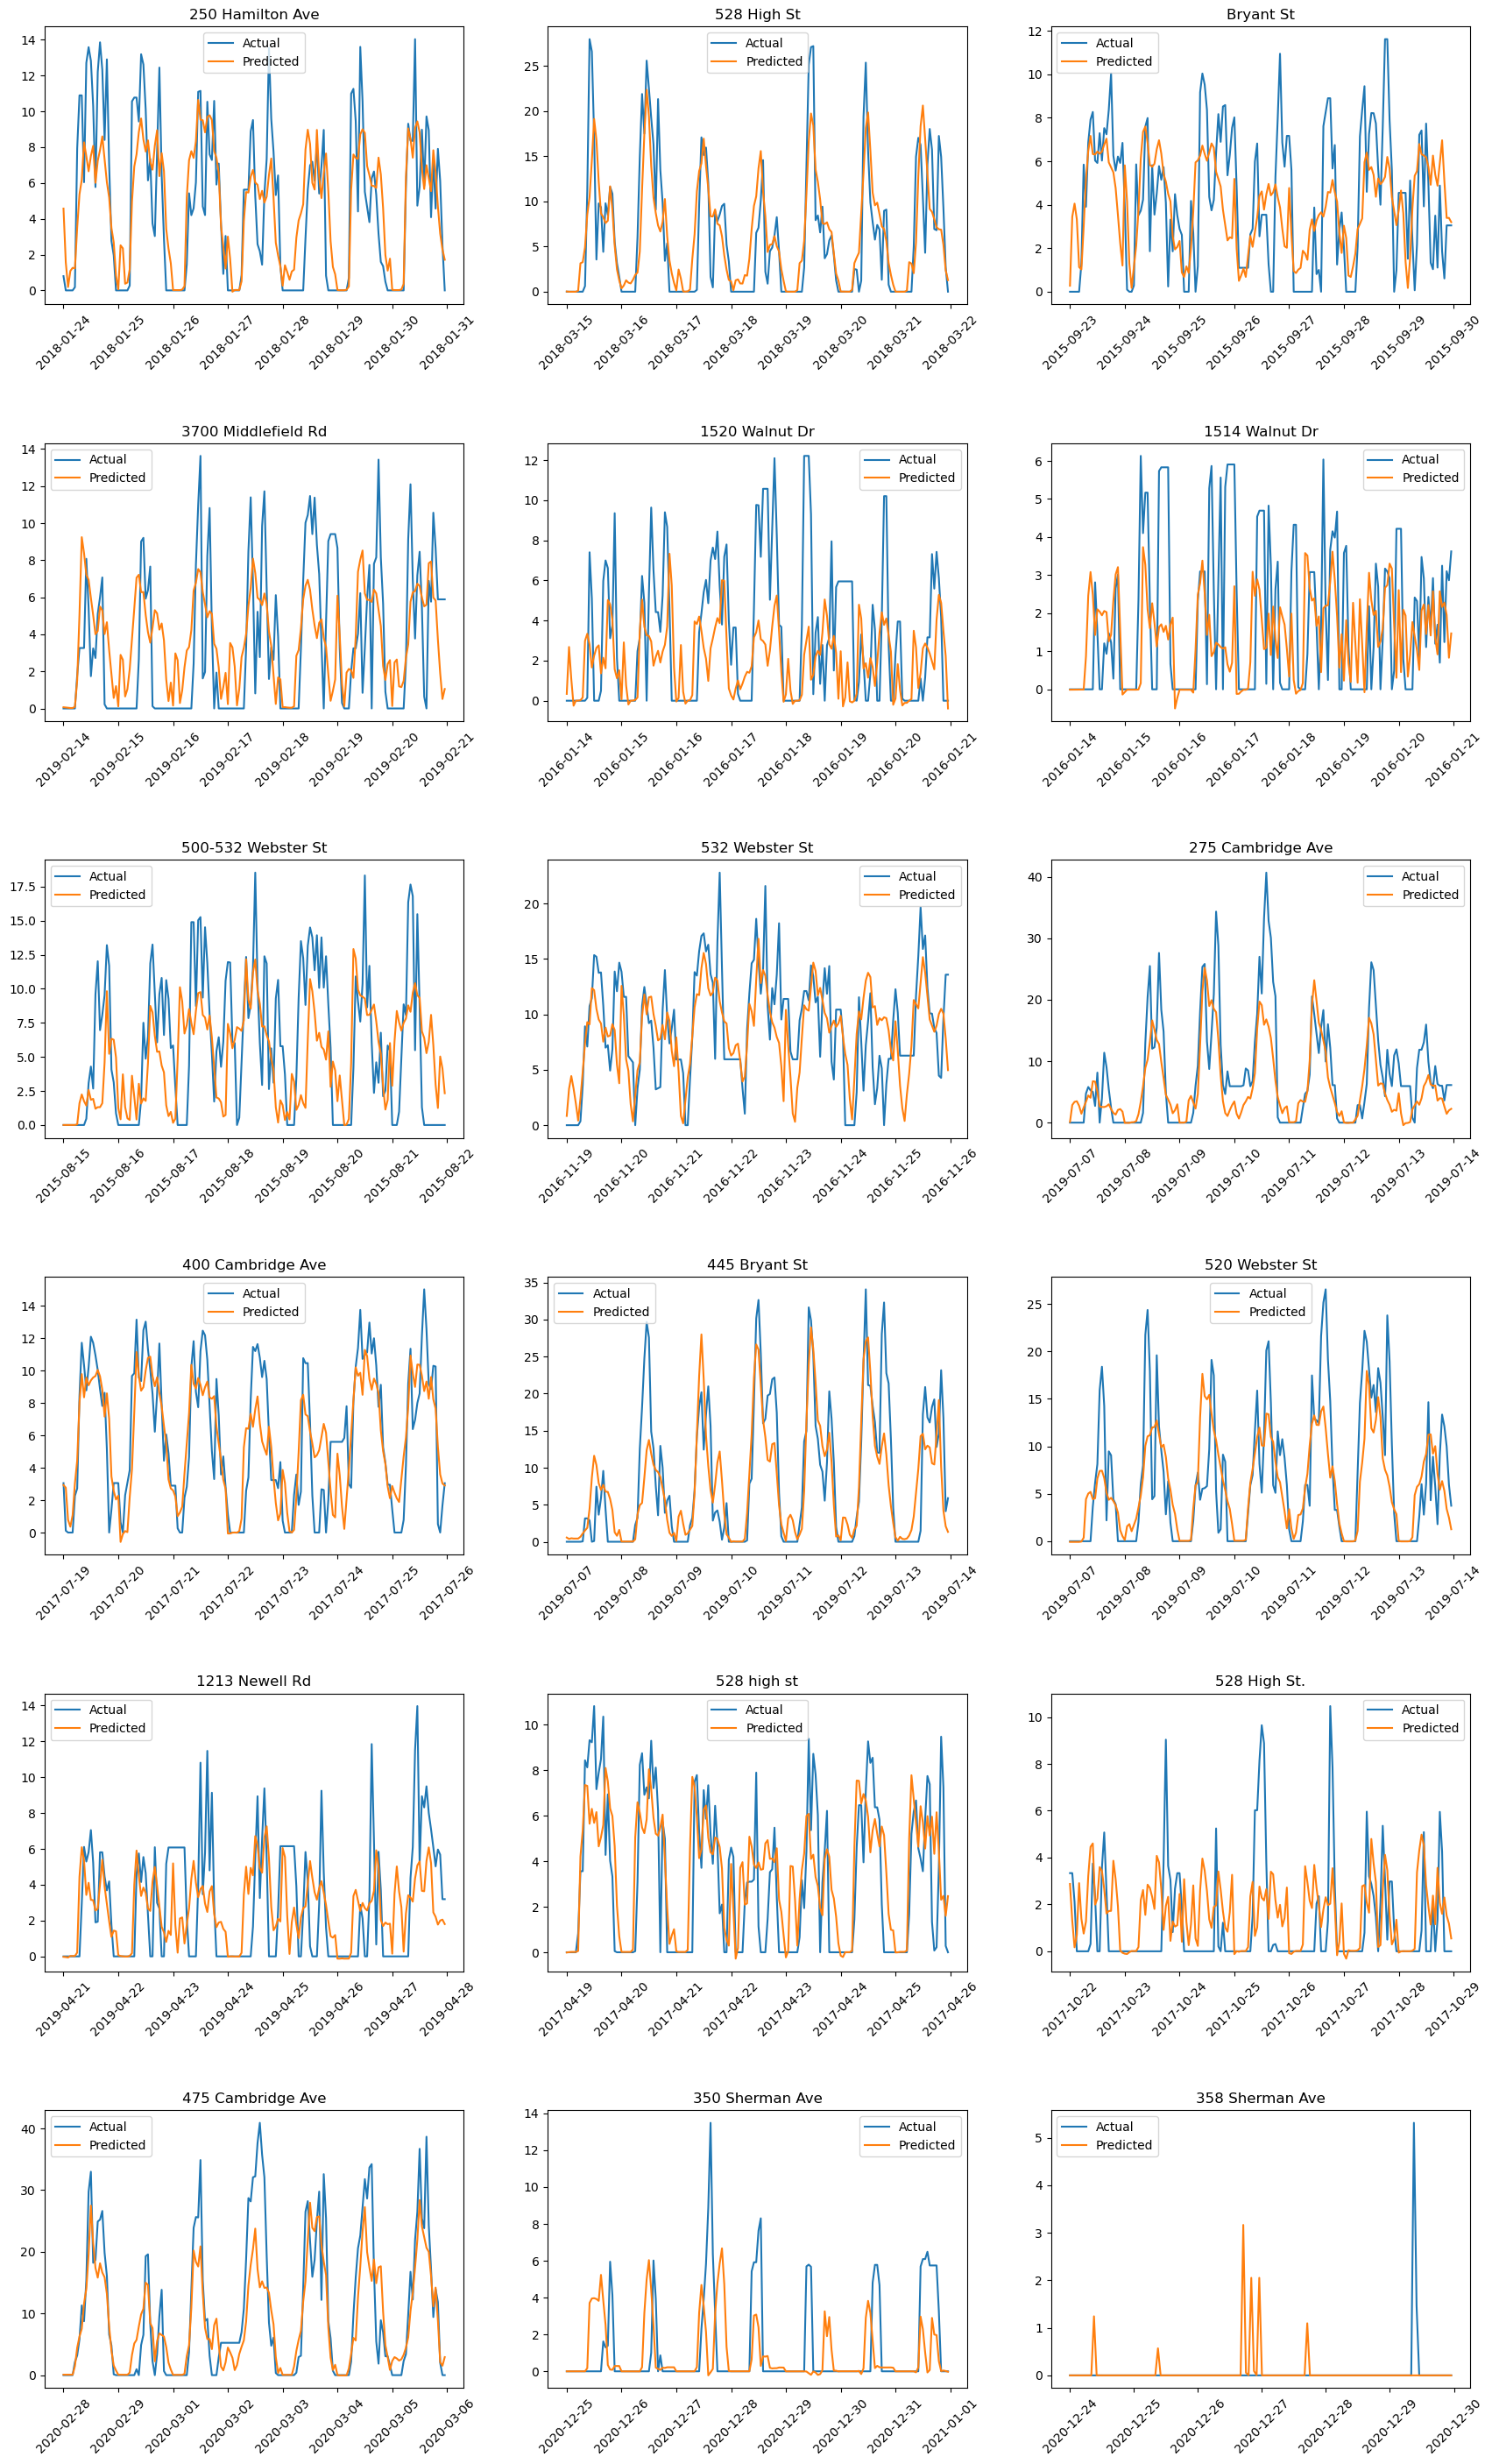

In [21]:
models = dict()
xgb_predictions = []
for station_name, hourly_df in training_data.items():
    model = train_model(hourly_df, "Consumption")
    if model is not None:
        models[station_name] = model
    else:
        print(f"Skipping {station_name} due to insufficient data")
        continue

    targets = test_data[station_name]
    if limit_in_days is not None:
        targets = targets.iloc[:limit_in_days * 24]
    last_known_data = hourly_df.iloc[-max(lags):]
    xgb_prediction = test_model(model, targets, last_known_data)
    stats.loc[station_name]["r^2 XGBoost"] = r2_score(targets, xgb_prediction)
    stats.loc[station_name]["MAE XGBoost"] = mean_absolute_error(targets, xgb_prediction)
    xgb_predictions.append(xgb_prediction)
plot_all_predicted_vs_actual(test_data.values(), xgb_predictions, list(training_data.keys()))

## Comparison

We can already see from the graph that this model does a better job of predicting than the baseline model. To see it more precisely, we look at r^2 and MAE metrics.

In [22]:
stats["r^2 Baseline"] = stats["r^2 Baseline"].apply(lambda x: x if -2 < x < 2 else None)
print(stats.mean())

r^2 Baseline    -0.01449
MAE Baseline     3.30232
r^2 XGBoost     0.208011
MAE XGBoost     2.546383
dtype: object


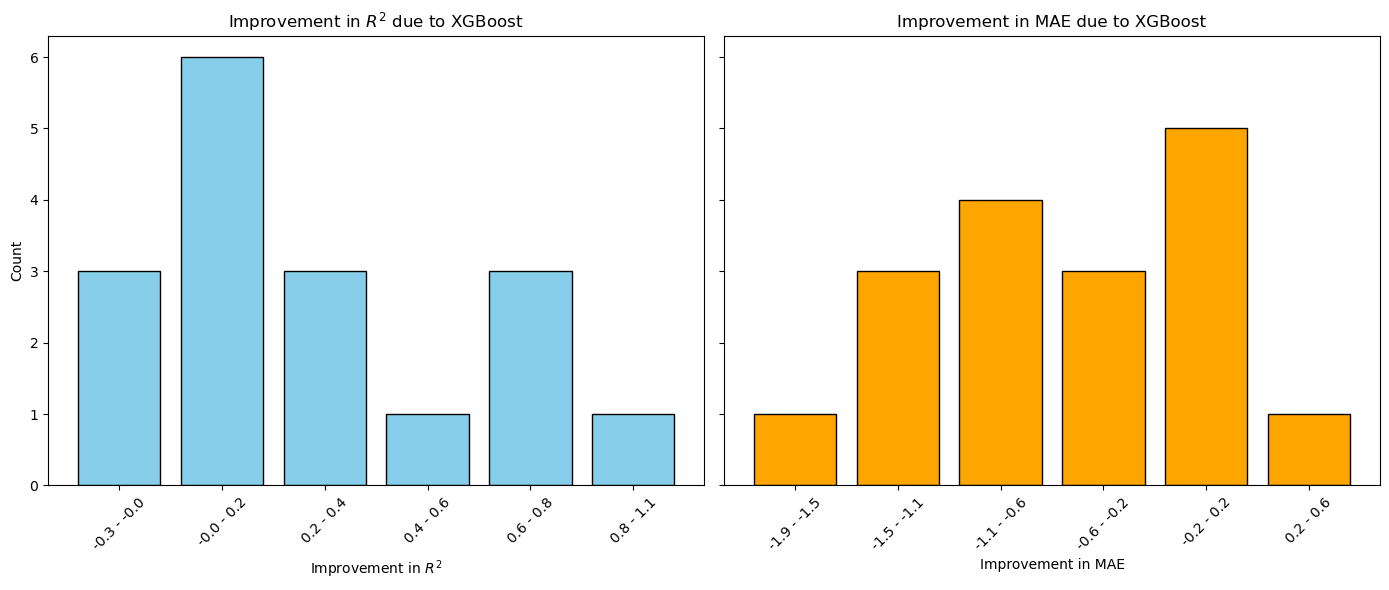

In [ ]:
bins = 6
stats.dropna(inplace=True)

# Compute histograms for R^2
r2_counts, r2_bin_edges = np.histogram(stats["r^2 XGBoost"] - stats["r^2 Baseline"], bins=bins)
r2_bin_labels = [f"{r2_bin_edges[i]:.1f} - {r2_bin_edges[i+1]:.1f}" for i in range(len(r2_bin_edges) - 1)]

# Compute histograms for MAE
mae_counts, mae_bin_edges = np.histogram(stats["MAE XGBoost"] - stats["MAE Baseline"], bins=bins)
mae_bin_labels = [f"{mae_bin_edges[i]:.1f} - {mae_bin_edges[i+1]:.1f}" for i in range(len(mae_bin_edges) - 1)]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# R^2 plot
axes[0].bar(range(len(r2_counts)), r2_counts, color="skyblue", edgecolor="black")
axes[0].set_xticks(range(len(r2_counts)))
axes[0].set_xticklabels(r2_bin_labels, rotation=45)
axes[0].set_title("Improvement in $R^2$ due to XGBoost compared to baseline")
axes[0].set_xlabel("Improvement in $R^2$")
axes[0].set_ylabel("Count")

# MAE plot
axes[1].bar(range(len(mae_counts)), mae_counts, color="orange", edgecolor="black")
axes[1].set_xticks(range(len(mae_counts)))
axes[1].set_xticklabels(mae_bin_labels, rotation=45)
axes[1].set_title("Improvement in MAE due to XGBoost compared to baseline")
axes[1].set_xlabel("Improvement in MAE")

# Adjust layout
plt.tight_layout()
plt.show()



The graphes show how the metrics change by using XGBoost model instead of the baseline one. We can see the change in R^2 is significantly positive and in MAE significantly negative, what is what we wanted. Both show that the XGBoost model has a better predictive power compared to the baseline model.